In [20]:
import numpy as np
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt

from IPython.display import display as dsp
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
#TODO: Change focus from authorship to quality / price

Data taken from kaggle
https://www.kaggle.com/zynicide/wine-reviews

# The Wine Review List

What we have here is a dataset of wine reviews from the Wine Enthusiast magazine (https://www.winemag.com/?s=&drink_type=wine). This dataset has gained popularity as a training set to measure the capabilities of various classifiers, clustering algorithms and natural language processing models.

There are several reasons why this dataset is so good for testing machine learning processes. First, the immense size of the dataset (at over 100'000 entries, each with a paragraph of text written by dozens of unique authors, with several other unique attributes such as title of the wine, type of wine, country of origin et al.

There are dozens of potential projects, such as supervised learning techniques involving predicting the authorship of the wine review based on the metrics of the review itself, or unsupervised techniques such as clustering reviews and wine types.

## The Data

We will first explore the form our data takes. We import the data as a pandas dataframe from a CSV file. There are several potential projects we could do using only a handful of columns from the original dataset, and thankfully, not very many entries countained null values we had to get rid of.

We will start by exploring a subset of the columns available from the raw dataset, being: 'description', 'title', 'country', 'taster_name', and 'variety'.

In [19]:
raw = pd.read_csv('wine-reviews/winemag-data-130k-v2.csv')
print('The raw dataset has {} columns.'.format(len(raw.columns)))
print(raw.columns)

#print((raw['points'].unique()))
#dsp(raw.head())

data = raw[['description', 'points', 'price', 'title', 'country', 'taster_name', 'variety']]
data.dropna(inplace = True)

print("Original dataframe shape:{}".format(raw.shape))
print("Final data shape:{}".format(data.shape))

The raw dataset has 14 columns.
Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')
Original dataframe shape:(129971, 14)
Final data shape:(96420, 7)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
#Clean Text
def text_cleaner(text):
    
    #Start by ensuring all excess whitespace is eliminated
    text = ' '.join(text.split())

#Iterate over all entries
data['description'] = data['description'].apply(lambda x: text_cleaner(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## The Proposal

Suppose we were a winery looking to perfect our formula with the goal of being a hit with the critics and either maximizing or minimizing the price point. Our approach to this problem would be to use natural language processing to find what concepts (flavors, scents et al) most strongly correlate to our business goals.

For our purposes, we will assume that the price of the wine perfectly correlates with the manufacturing cost, and an optimal solution would be to maximize the quality to price ratio. We will first formulate an outcome variable and measure its intrisic properties.

There are a total of 381 unique prices over 96420 reviews.
There are a total of 21 unique ratings over 96420 reviews.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


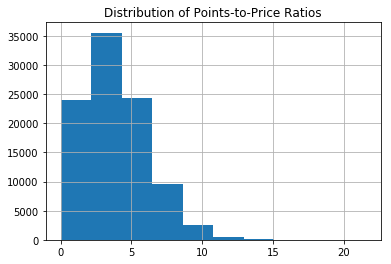

In [22]:
print('There are a total of {} unique prices over {} reviews.'
      .format(len(data['price'].unique()), data.shape[0]))

print('There are a total of {} unique ratings over {} reviews.'
      .format(len(data['points'].unique()), data.shape[0]))

#Create outcome variable
data['points-to-price'] = data['points'] / data['price']

#Plot histogram of outcome
plt.title('Distribution of Points-to-Price Ratios')
data['points-to-price'].hist()



## Straight Points-to-Price Model

__The Good News__


The distribution of prices are close to normally distributed. The largest subdivisions don't terribly outweigh each other.

__The Bad News__

There will still be an imbalance between lower and higher values that we will need to account for in our final model.

## Clustering Reviews by Language

To get a better idea of the linguistics used in our wine reviews, we will use unsupervised clustering techniques to group similar reviews. We can use this information to determine if there are dramatic differences in review styles and which authors tend to write what styles. We may even pull out certain attributes associated with these styles.

There are several clustering techniques we could use, but the process by which we begin the process of modeling essentially begin the same; our linguistic observations (paragraphs, pages et al) are turned into vectors. One method of doing so is called the 'term-document matrix' (tdf). In tdf, stopwords such as 'the', 'is', 'and' et. al. are ignored, all other words are reduced to their lemmas (tasting => taste), and the presence-absense of each word (or the frequency therein) is encoded in a matrix in which each row represents a document, and each column represents a term.

As it goes, words that appear often (such as the word 'wine' in our wine reviews) are much less impactful than less common words. We therefore need to penalize words that occur too often by calculating the inverse document frequency.

In [37]:
#Set up our tf-idf model
tfidf = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Split number
spl = 1000

#Split data into training and test set
data_train = data[spl:]
data_test = data[:spl]

#We need to split our features seperately, as the vectorization process returns data in a different format
X = tfidf.fit_transform(data['description'])

#We can do this because the index carries over
X_train = X[spl:]
X_test = X[:spl]

#Set up our outcomes
Y_train, Y_test = data_train['points-to-price'], data_test['points-to-price']

#Lets explore our features
print('Number of linguistic features: {} {}'.format(X_train.shape[1], X_test.shape[1]))

Number of linguistic features: 17391 17391


### The Clustering Process

We will now cluster our vectorized documents using